In [1]:
import pandas as pd
from fastopic import FASTopic
from sklearn.feature_extraction.text import CountVectorizer
from topmost.preprocessing import Preprocessing
import matplotlib.pyplot as plt    

c:\Users\xpetr\.conda\envs\FASTopic_testing\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data= pd.read_excel("data_emails.xlsx")
head = data.head(3)
styled_head = head.style.set_table_styles(
    [{'selector': 'th', 'props': [('text-align', 'left'), ('font-size', '12pt')]}, #colums
     {'selector': 'td', 'props': [('text-align', 'left'), ('font-size', '10pt')]}] # text
)
display(styled_head)

,subject,sender,message,message_clean
0,Mercury Language Documentation Issue,john.doe@example.com,"Hi Aetheros Support, I'm having trouble finding clear documentation on how to implement custom error handling in Mercury. The examples in the current documentation seem outdated and don't align with the latest version I'm using. Could you please point me to the correct resources or provide some guidance on this? Thanks, John Doe",aethero support trouble find clear documentation implement custom error handle mercury example current documentation outdate align late version use point correct resource provide guidance this thank john doe
1,URGENT: User Permission Errors in Production API,kenneth77@davis-becker.com,We are experiencing critical issues with user permissions on our production API (API key: aeth-prod-28374). Users with the correct roles are being denied access to endpoints they should have access to. This is causing major disruption to our services. We need immediate assistance to resolve this. We believe the issue might be related to recent changes we made in the IAM service regarding role assignments. We can provide more details on the specific roles and endpoints affected if needed.,experience critical issue user permission production api api key aeth prod user correct role deny access endpoint access to cause major disruption service assistance resolve this issue iam service role assignment provide detail specific role endpoint need
2,URGENT: Mercury Code Deployment Failing with Error 502,john.doe@example.com,"Hi Aetheros Support, We are experiencing urgent issues deploying our Mercury code to production. We are consistently getting a 502 error, and our API monitoring dashboard is showing a spike in errors. This is causing a major outage for our services. We have checked our code and cannot identify the issue. Can you please investigate ASAP? Thanks, John Doe",aethero support experience urgent issue deploy mercury code production consistently error api monitor dashboard show spike error cause major outage service check code identify issue investigate asap thanks john doe


In [3]:
# 1. FASTopic, training
# Create a list of speeches
docs = data['message_clean'].tolist()

In [4]:
# Custom preprocessing class to prepare bigrams for the model
class NgramPreprocessing:
    def __init__(self, ngram_range=(1, 1),
                       vocab_size=10000,
                       stopwords='English'):

        self.ngram_range = ngram_range
        self.preprocessing = Preprocessing(vocab_size=vocab_size,
                                           stopwords=stopwords)

        # Use a custom analyzer to join bigrams with "_"
        self.vectorizer = CountVectorizer(ngram_range=self.ngram_range,
                                          max_features=vocab_size,
                                          analyzer=self._custom_analyzer)

    # Custom analyzer function to join bigrams with underscores
    def _custom_analyzer(self, doc):
        # Tokenize the document and create bigrams
        tokens = CountVectorizer(ngram_range=self.ngram_range).build_analyzer()(doc)

        # Replace spaces in bigrams with "_"
        return [token.replace(" ", "_") for token in tokens]

    def preprocess(self,
                   docs,
                   pretrained_WE=False):

        parsed_docs = self.preprocessing.preprocess(docs,
                      pretrained_WE=pretrained_WE)["train_texts"]
        train_bow = self.vectorizer.fit_transform(parsed_docs).toarray()
        rst = {
            "train_bow": train_bow,
            "train_texts": parsed_docs,
            "vocab": self.vectorizer.get_feature_names_out()
        }
        return rst

# Initialize preprocessing with bigrams
ngram_preprocessing = NgramPreprocessing(ngram_range=(2, 2))

In [5]:
# Set random seeds before running FASTopic to get the same results every time

import numpy as np
import torch

torch.manual_seed(0)
np.random.seed(0)

In [6]:
# Model training
topic_size  = 8
top_words = 15

model = FASTopic(topic_size, ngram_preprocessing,num_top_words=top_words)

# Fit model to documents
topic_top_words, probabilities = model.fit_transform(docs)

parsing texts: 100%|██████████| 692/692 [00:00<00:00, 23756.18it/s]
2025-04-21 19:52:06,376 - TopMost - Real vocab size: 1439
2025-04-21 19:52:06,378 - TopMost - Real training size: 692 	 avg length: 33.740
Training FASTopic: 100%|██████████| 200/200 [00:19<00:00, 10.17it/s]


In [7]:
print(len(probabilities))

692


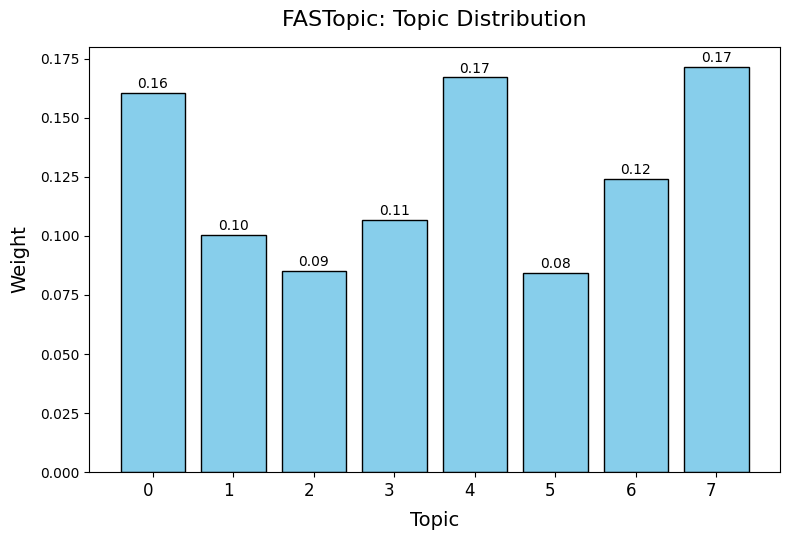

In [8]:
# 2. FASTopic, topic distribution for a T8 model

# Retrieve and process topic weights
topic_weights = model.get_topic_weights()
topic_weights_df = pd.DataFrame(topic_weights, columns=['Weight']).reset_index()
topic_weights_df.rename(columns={'index': 'Topic'}, inplace=True)

# Ensure 'Weight' is numeric and sort by Topic number
topic_weights_df['Weight'] = pd.to_numeric(topic_weights_df['Weight'], errors='coerce')
topic_weights_sorted = topic_weights_df.sort_values(by='Topic', ascending=True)

# Configure the plot
plt.figure(figsize=(8, 5.5))
bars = plt.bar(
    topic_weights_sorted['Topic'].astype(str),
    topic_weights_sorted['Weight'],
    color='skyblue',
    edgecolor='black'
)

# Add axis labels and title
plt.xlabel('Topic', fontsize=14, labelpad=8)
plt.ylabel('Weight', fontsize=14, labelpad=8)
plt.title('FASTopic: Topic Distribution', fontsize=16, pad=15)

# Rotate x-axis labels for better readability
plt.xticks(fontsize=12, ha='right')

# Add data labels above each bar
for bar in bars:
    plt.text(
        bar.get_x() + bar.get_width() / 2, 
        bar.get_height() + 0.002,  # Adjust the position slightly above the bar
        f'{bar.get_height():.2f}',  # Format the label to 2 decimal places
        ha='center', 
        fontsize=10
    )

# Adjust layout and display the plot
plt.savefig('FAST_topic_distribution.png', dpi=400)
plt.tight_layout()
plt.show()

In [9]:
# 3. FASTopic, display top words in a dataframe
# Retrieve the bigrams for each topic and select only the word columns
topic_0 = pd.DataFrame(model.get_topic(0, top_words), columns=["T0", "Prob_0"])
topic_1 = pd.DataFrame(model.get_topic(1, top_words), columns=["T1", "Prob_1"])
topic_2 = pd.DataFrame(model.get_topic(2, top_words), columns=["T2", "Prob_2"])
topic_3 = pd.DataFrame(model.get_topic(3, top_words), columns=["T3", "Prob_3"])
topic_4 = pd.DataFrame(model.get_topic(4, top_words), columns=["T4", "Prob_4"])
topic_5 = pd.DataFrame(model.get_topic(5, top_words), columns=["T5", "Prob_5"])
topic_6 = pd.DataFrame(model.get_topic(6, top_words), columns=["T6", "Prob_6"])
topic_7 = pd.DataFrame(model.get_topic(7, top_words), columns=["T7", "Prob_7"])
# topic_8 = pd.DataFrame(model.get_topic(8, top_words), columns=["T8", "Prob_8"])
# topic_9 = pd.DataFrame(model.get_topic(9, top_words), columns=["T9", "Prob_9"])

topics_df = pd.concat([topic_0, topic_1, topic_2, topic_3, topic_4,topic_5,topic_6, topic_7], axis=1)
# topics_df = pd.concat([topic_0, topic_1, topic_2, topic_3, topic_4,topic_5,topic_6, topic_7,topic_8,topic_9], axis=1)

# Keep only predicted bigrams, leave out probabilities
topics_df = topics_df.loc[:, topics_df.columns.str.startswith('T')]

In [10]:
topics_df

,T0,T1,T2,T3,T4,T5,T6,T7
0,peak_hour,error_handle,spike_api,issue_user,monitor_dashboard,incredibly_beneficial,service_specifically,deploy_mercury
1,experience_difficulty,error_handling,latency_spike,deny_error,api_performance,improvement_api,role_inheritance,priority_issue
2,scale_cloud,project_mercury,provide_urgent,error_access,time_resolution,improvement_cloud,role_base,issue_deploy
3,times_api,work_project,support_notice,deny_access,estimate_time,service_month,inherit_permission,encounter_error
4,slow_response,clear_documentation,cause_thank,user_report,average_response,suggestion_dashboard,achieve_thank,compiler_error
5,latency_api,trouble_clear,notice_unusual,access_cause,environment_experience,improvement_iam,role_inherit,advise_proceed
6,difficulty_scale,async_await,follow_pattern,api_fail,false_positive,service_incredibly,trouble_set,unexpected_token
7,experience_performance,documentation_implement,intermittent_high,update_iam,potential_issue,dashboard_currently,custom_role,multiple_time
8,cloud_cost,work_mercury,notice_intermittent,iam_integration,environment_host,current_dashboard,specific_permission,unable_assign
9,application_experience,handle_asynchronous,root_resolve,unauthorized_access,experience_severe,improve_user,role_access,trouble_deploy


In [11]:
# Remove underscores to show bigrams
topics_df = topics_df.applymap(lambda x: x.replace('_', ' ') if isinstance(x, str) else x)
topics_df = topics_df.loc[:, topics_df.columns.str.startswith('T')]
topics_df

,T0,T1,T2,T3,T4,T5,T6,T7
0,peak hour,error handle,spike api,issue user,monitor dashboard,incredibly beneficial,service specifically,deploy mercury
1,experience difficulty,error handling,latency spike,deny error,api performance,improvement api,role inheritance,priority issue
2,scale cloud,project mercury,provide urgent,error access,time resolution,improvement cloud,role base,issue deploy
3,times api,work project,support notice,deny access,estimate time,service month,inherit permission,encounter error
4,slow response,clear documentation,cause thank,user report,average response,suggestion dashboard,achieve thank,compiler error
5,latency api,trouble clear,notice unusual,access cause,environment experience,improvement iam,role inherit,advise proceed
6,difficulty scale,async await,follow pattern,api fail,false positive,service incredibly,trouble set,unexpected token
7,experience performance,documentation implement,intermittent high,update iam,potential issue,dashboard currently,custom role,multiple time
8,cloud cost,work mercury,notice intermittent,iam integration,environment host,current dashboard,specific permission,unable assign
9,application experience,handle asynchronous,root resolve,unauthorized access,experience severe,improve user,role access,trouble deploy


In [12]:
topics_df.to_excel('FASTopic_8_TOP_15.xlsx', index=False)

In [13]:
# 4. Coherence evaluation
# 4.1. NPMI
NPMI = pd.read_csv('NPMI_mailing.csv')
NPMI.head(3)

,bigram,bigram_synonym,npmi
0,customer support,support customer,0.737688
1,issue resolve,resolve issue,0.362632
2,datum medical,medical datum,0.499741


In [ ]:
# Merge bigrams predicted by FASTopic and BERTopic with their NPMI scores from the reference corpus. The fewer NaNs are in the table, the more accurate the metric is.

topics_df = pd.merge(topics_df, NPMI, left_on='T0', right_on='bigram', how='left')
topics_df = pd.merge(topics_df, NPMI, left_on='T0', right_on='bigram_synonym', how='left')

topics_df['npmi'] = topics_df['npmi_x'].fillna(topics_df['npmi_y'])
topics_df.drop(columns=['npmi_x', 'npmi_y','bigram_x','bigram_synonym_x','bigram_y','bigram_synonym_y'], inplace=True)
topics_df.rename(columns={'npmi': 'NPMI_T0'}, inplace=True)

In [15]:
topics_df = pd.merge(topics_df, NPMI, left_on='T1', right_on='bigram', how='left')
topics_df = pd.merge(topics_df, NPMI, left_on='T1', right_on='bigram_synonym', how='left')

topics_df['npmi'] = topics_df['npmi_x'].fillna(topics_df['npmi_y'])
topics_df.drop(columns=['npmi_x', 'npmi_y','bigram_x','bigram_synonym_x','bigram_y','bigram_synonym_y'], inplace=True)
topics_df.rename(columns={'npmi': 'NPMI_T1'}, inplace=True)

In [16]:
topics_df = pd.merge(topics_df, NPMI, left_on='T2', right_on='bigram', how='left')
topics_df = pd.merge(topics_df, NPMI, left_on='T2', right_on='bigram_synonym', how='left')

topics_df['npmi'] = topics_df['npmi_x'].fillna(topics_df['npmi_y'])
topics_df.drop(columns=['npmi_x', 'npmi_y','bigram_x','bigram_synonym_x','bigram_y','bigram_synonym_y'], inplace=True)
topics_df.rename(columns={'npmi': 'NPMI_T2'}, inplace=True)

In [17]:
topics_df = pd.merge(topics_df, NPMI, left_on='T3', right_on='bigram', how='left')
topics_df = pd.merge(topics_df, NPMI, left_on='T3', right_on='bigram_synonym', how='left')

topics_df['npmi'] = topics_df['npmi_x'].fillna(topics_df['npmi_y'])
topics_df.drop(columns=['npmi_x', 'npmi_y','bigram_x','bigram_synonym_x','bigram_y','bigram_synonym_y'], inplace=True)
topics_df.rename(columns={'npmi': 'NPMI_T3'}, inplace=True)

In [18]:
topics_df = pd.merge(topics_df, NPMI, left_on='T4', right_on='bigram', how='left')
topics_df = pd.merge(topics_df, NPMI, left_on='T4', right_on='bigram_synonym', how='left')

topics_df['npmi'] = topics_df['npmi_x'].fillna(topics_df['npmi_y'])
topics_df.drop(columns=['npmi_x', 'npmi_y','bigram_x','bigram_synonym_x','bigram_y','bigram_synonym_y'], inplace=True)
topics_df.rename(columns={'npmi': 'NPMI_T4'}, inplace=True)

In [19]:
topics_df = pd.merge(topics_df, NPMI, left_on='T5', right_on='bigram', how='left')
topics_df = pd.merge(topics_df, NPMI, left_on='T5', right_on='bigram_synonym', how='left')

topics_df['npmi'] = topics_df['npmi_x'].fillna(topics_df['npmi_y'])
topics_df.drop(columns=['npmi_x', 'npmi_y','bigram_x','bigram_synonym_x','bigram_y','bigram_synonym_y'], inplace=True)
topics_df.rename(columns={'npmi': 'NPMI_T5'}, inplace=True)

In [20]:
topics_df = pd.merge(topics_df, NPMI, left_on='T6', right_on='bigram', how='left')
topics_df = pd.merge(topics_df, NPMI, left_on='T6', right_on='bigram_synonym', how='left')

topics_df['npmi'] = topics_df['npmi_x'].fillna(topics_df['npmi_y'])
topics_df.drop(columns=['npmi_x', 'npmi_y','bigram_x','bigram_synonym_x','bigram_y','bigram_synonym_y'], inplace=True)
topics_df.rename(columns={'npmi': 'NPMI_T6'}, inplace=True)

In [21]:
topics_df = pd.merge(topics_df, NPMI, left_on='T7', right_on='bigram', how='left')
topics_df = pd.merge(topics_df, NPMI, left_on='T7', right_on='bigram_synonym', how='left')

topics_df['npmi'] = topics_df['npmi_x'].fillna(topics_df['npmi_y'])
topics_df.drop(columns=['npmi_x', 'npmi_y','bigram_x','bigram_synonym_x','bigram_y','bigram_synonym_y'], inplace=True)
topics_df.rename(columns={'npmi': 'NPMI_T7'}, inplace=True)

In [22]:
# topics_df = pd.merge(topics_df, NPMI, left_on='T8', right_on='bigram', how='left')
# topics_df = pd.merge(topics_df, NPMI, left_on='T8', right_on='bigram_synonym', how='left')

# topics_df['npmi'] = topics_df['npmi_x'].fillna(topics_df['npmi_y'])
# topics_df.drop(columns=['npmi_x', 'npmi_y','bigram_x','bigram_synonym_x','bigram_y','bigram_synonym_y'], inplace=True)
# topics_df.rename(columns={'npmi': 'NPMI_T8'}, inplace=True)

In [23]:
# topics_df = pd.merge(topics_df, NPMI, left_on='T9', right_on='bigram', how='left')
# topics_df = pd.merge(topics_df, NPMI, left_on='T9', right_on='bigram_synonym', how='left')

# topics_df['npmi'] = topics_df['npmi_x'].fillna(topics_df['npmi_y'])
# topics_df.drop(columns=['npmi_x', 'npmi_y','bigram_x','bigram_synonym_x','bigram_y','bigram_synonym_y'], inplace=True)
# topics_df.rename(columns={'npmi': 'NPMI_T9'}, inplace=True)

In [24]:
topics_df

,T0,T1,T2,T3,T4,T5,T6,T7,NPMI_T0,NPMI_T1,NPMI_T2,NPMI_T3,NPMI_T4,NPMI_T5,NPMI_T6,NPMI_T7
0,peak hour,error handle,spike api,issue user,monitor dashboard,incredibly beneficial,service specifically,deploy mercury,0.833381,-0.103750,NaN,-0.020035,-0.177770,0.378867,-0.039775,NaN
1,experience difficulty,error handling,latency spike,deny error,api performance,improvement api,role inheritance,priority issue,0.207090,0.153264,0.529934,NaN,-0.152783,-0.145151,0.528246,-0.106117
2,scale cloud,project mercury,provide urgent,error access,time resolution,improvement cloud,role base,issue deploy,NaN,NaN,-0.067519,-0.025638,0.025870,-0.154200,NaN,-0.055657
3,times api,work project,support notice,deny access,estimate time,service month,inherit permission,encounter error,0.045128,-0.006230,0.031736,0.335809,0.208212,0.039092,NaN,0.119550
4,slow response,clear documentation,cause thank,user report,average response,suggestion dashboard,achieve thank,compiler error,0.110101,-0.152845,NaN,0.039777,NaN,-0.277188,NaN,NaN
5,latency api,trouble clear,notice unusual,access cause,environment experience,improvement iam,role inherit,advise proceed,NaN,0.058718,0.276865,-0.065225,NaN,NaN,NaN,0.010779
6,difficulty scale,async await,follow pattern,api fail,false positive,service incredibly,trouble set,unexpected token,NaN,NaN,NaN,0.215911,NaN,0.078370,NaN,NaN
7,experience performance,documentation implement,intermittent high,update iam,potential issue,dashboard currently,custom role,multiple time,0.094033,-0.075710,0.122177,NaN,-0.039325,-0.022376,0.583991,0.084596
8,cloud cost,work mercury,notice intermittent,iam integration,environment host,current dashboard,specific permission,unable assign,-0.007115,NaN,NaN,NaN,NaN,-0.021933,0.039212,NaN
9,application experience,handle asynchronous,root resolve,unauthorized access,experience severe,improve user,role access,trouble deploy,0.068573,NaN,0.055788,0.699507,0.067589,0.185004,-0.049673,NaN


In [25]:
# Calculate means for each NPMI column
NPMI_topics = topics_df[['NPMI_T0', 'NPMI_T1', 'NPMI_T2', 'NPMI_T3', 'NPMI_T4', 'NPMI_T5', 'NPMI_T6', 'NPMI_T7']].mean()
# NPMI_topics = topics_df[['NPMI_T0', 'NPMI_T1', 'NPMI_T2', 'NPMI_T3', 'NPMI_T4', 'NPMI_T5', 'NPMI_T6', 'NPMI_T7','NPMI_T8', 'NPMI_T9']].mean()

# Calculate overall NPMI
NPMI = float(format(round(NPMI_topics.mean(),3), '.3f'))
print("\nNPMI: {:.3f}".format(NPMI))


NPMI: 0.075


In [26]:
# 4.2 Semantic coherence by Mimmo et al. (2011)

# create a document-term matrix (DTM)
def bigram_tokenizer(text):                 # custom tokenizer to join bigrams with an underscore
    tokens = text.split()
    bigrams = [f"{tokens[i]}_{tokens[i+1]}" for i in range(len(tokens)-1)]
    return bigrams

vectorizer = CountVectorizer(tokenizer = bigram_tokenizer, ngram_range=(1, 1))

# create a DTM with count vectorizer
dtm = vectorizer.fit_transform(docs)

# create a vocabulary of bigrams
feature_names = vectorizer.get_feature_names_out()

In [27]:
# define a topic-words matrix
# join bigrams into tokens by replacing spaces with underscores in T8 BERTopic bigram table
topics_df = topics_df.applymap(lambda x: x.replace(' ', '_') if isinstance(x, str) else x)
topic_words_matrix = [topics_df[col].tolist() for col in topics_df.columns]

# convert to NumPy array and transpose for function compatibility
topic_words_matrix = np.array(topic_words_matrix).T

In [28]:
# calculate topic-level SC coherence, using the DTM and topic-words matrices

def topic_coherence(dtm, topic_words_matrix, feature_names, epsilon=1):
    topic_words_matrix = np.array(topic_words_matrix)
    coherence_scores = {}

    coherence_scores = []
    topics = []

    # Convert DTM to binary presence/absence matrix
    dtm_bin = (dtm > 0).astype(int)

    # Compute document frequency for each word (D_w)
    word_indices = {word: i for i, word in enumerate(feature_names)}
    D_w = np.array(dtm_bin.sum(axis=0)).flatten()

    # Iterate over topics
    for topic_idx in range(topic_words_matrix.shape[1]):
        topic_words = topic_words_matrix[:, topic_idx]
        coherence_score = 0.0  # Initialize coherence score 

        # Iterate over word pairs
        for i in range(1, len(topic_words)):
            for j in range(i):
                w_i, w_j = topic_words[i], topic_words[j]

                # Skip words not in vocabulary
                if w_i not in word_indices or w_j not in word_indices:
                    continue

                # Get indices for words
                idx_i, idx_j = word_indices[w_i], word_indices[w_j]

                # Compute co-occurrence (D_wi_wj)
                D_wi_wj = np.sum(dtm_bin[:, idx_i].multiply(dtm_bin[:, idx_j]))

                # Apply coherence formula
                if D_w[idx_j] > 0:
                    coherence_score += np.log((D_wi_wj + epsilon) / D_w[idx_j])

        coherence_scores.append(coherence_score)
        topics.append(topic_idx)

    return coherence_scores, topics

In [29]:
sc_topics, topics = topic_coherence(dtm, topic_words_matrix, feature_names, epsilon=1)

In [30]:
# average topic SC to a model SC score
sc_topics= pd.DataFrame(sc_topics, index=topics, columns=['score'])
SC=sc_topics['score'].mean()
print("\nSemantic Coherence: {:.2f}".format(SC))


Semantic Coherence: -97.97


In [31]:
# 5. Topic diversity evaluation, PUV (Percentage of Unique Words)
# calculate topic diversity as count of distinct tokens/ count of tokens in the tables for a model

def puv(data): 
    total_word_count = 0
    total_unique_words = set()

    for column in data.columns: 
        if column.startswith('T'): 
            all_text = ' '.join(data[column].astype(str).tolist())         
            words = all_text.split() 

            total_word_count += len(words)
            total_unique_words.update(words)

    total_unique_word_count = len(total_unique_words)
    td = round(total_unique_word_count / total_word_count, 3) if total_word_count > 0 else 0

    return td

In [32]:
TD = puv(topics_df)
print("\nTopic Diversity: {:.2f}".format(TD))


Topic Diversity: 1.00


In [33]:
# Use the trained model to classify email communication
# Define labels for each topic
topic_labels = {
    0: "Time Delays",
    1: "Compilation Errors",
    2: "Latency Issues",
    3: "Authorization errors",
    4: "Time Delays",
    5: "Improvement Suggestions",
    6: "User Permissions",
    7: "Deployment Issues"
}

# Get the topic with highest probability for each document
topic = np.argmax(probabilities, axis=1)
data["topic"] = topic

# Map numeric topics to their labels
data["content"] = data["topic"].map(topic_labels)

# Create outcome DataFrame with message, and topic label
outcome = pd.DataFrame(data, columns=["message",  "content"])

styled_head = outcome.head(10).style.set_table_styles(
    [{'selector': 'th', 'props': [('text-align', 'left'), ('font-size', '12pt')]}, #colums
     {'selector': 'td', 'props': [('text-align', 'left'), ('font-size', '10pt')]}] # text
)
display(styled_head)

,message,content
0,"Hi Aetheros Support, I'm having trouble finding clear documentation on how to implement custom error handling in Mercury. The examples in the current documentation seem outdated and don't align with the latest version I'm using. Could you please point me to the correct resources or provide some guidance on this? Thanks, John Doe",Compilation Errors
1,We are experiencing critical issues with user permissions on our production API (API key: aeth-prod-28374). Users with the correct roles are being denied access to endpoints they should have access to. This is causing major disruption to our services. We need immediate assistance to resolve this. We believe the issue might be related to recent changes we made in the IAM service regarding role assignments. We can provide more details on the specific roles and endpoints affected if needed.,Authorization errors
2,"Hi Aetheros Support, We are experiencing urgent issues deploying our Mercury code to production. We are consistently getting a 502 error, and our API monitoring dashboard is showing a spike in errors. This is causing a major outage for our services. We have checked our code and cannot identify the issue. Can you please investigate ASAP? Thanks, John Doe",Latency Issues
3,"Hi Aetheros Support Team, I'm writing to suggest an improvement to your API development process. Currently, the documentation for error codes returned by the APIs seems a bit sparse. It would be incredibly helpful if you could provide more detailed explanations of each error code, including potential causes and suggested solutions. This would greatly expedite troubleshooting and integration. Thanks, Isabella Garcia",Compilation Errors
4,"Hi Aetheros Support, I have a quick question about the API Monitoring dashboard. Is it possible to customize the widgets displayed, and if so, how can I do that? Thanks, John Doe",Improvement Suggestions
5,"Hi Aetheros Support, I've been noticing some unusual latency spikes with my API over the past few days. It's not consistent, but it's happening frequently enough to be concerning. Could you take a look and see if there's anything on the monitoring side that might be causing this? Thanks, John Doe",Latency Issues
6,"Hi Aetheros Support, One of our production server instances managed through your Cloud Management service is currently unreachable. This is causing significant downtime and impacting our customers. The instance name is ""prod-app-server-01"". Can you please investigate this issue with high priority and provide an update as soon as possible? Thanks, John Doe",Time Delays
7,"Hi Aetheros Support, We are currently using your Cloud Management service and are very happy with the features and performance. However, we're looking to implement rate limiting on some of our APIs that are managed by Aetheros Cloud Management. Could you please provide some information on how we can achieve this? Is there built-in functionality within the Cloud Management platform for API rate limiting, or are there recommended third-party tools that integrate well with your system? Thank you for your time and assistance. Sincerely, Isiah Rippin",Improvement Suggestions
8,"Hi Aetheros Support, We've been experiencing intermittent latency spikes with our API that are being flagged by your API Monitoring service. These spikes are impacting our application performance and are concerning. Additionally, we've noticed a significant increase in our cloud costs recently. We're unsure if this is related to the API issues or something else entirely. Could you please help us investigate both of these matters? Thanks, Kenneth",Latency Issues
9,"Hi Aetheros Support Team, I've been using your API monitoring platform for a few months now, and it's been incredibly helpful in tracking our API performance. However, I have a suggestion for the dashboard. Currently, the response time graph only shows the average response time. It would be extremely beneficial if we could also visualize the 